# Оптимизация нейросетей. Дропаут.


# План семинара:

* recap
* Задачи/ф-ии потерь
* Метрики
* Регуляризация
* Добавляем LR Sheduler в трейнер
* LR Sheduler
* WarmUp
* Блиц



# Recap

### 🧮 Мотивация

Нейронная сеть -- большая формула с коэффициентами (весами).

Нейросети сами выучивают признаки, которые важны для предикта. Не надо заниматься фича-инженирингом.

### 📉 Градиенты

Для вычисления градиентов весов мы используем алгоритм обратного распространения ошибки. Когда градиенты вычислены, оптимизатор делает шаг оптимимзации.

### 📏 Нелинейность

Если из нейросети убрать все нелинейные преобразования, она выродится в линейную регрессию. `ReLU` - неплохой бейзлайн для ф-и активации.

### 🔮 Инициализация

Веса нейросети по умолчанию инициализируются рандомно. Но можно изменять алгоритмы инициализации весов и это может существенно.

### 🔎 Метрики

TL; DR:
- тренировочные метрики нужно записывать без сглаживания с каждого батча
- валидационные собирать за всю валидацию и рисовать одной точкой


**Особенности TensorBoard**:

- При отображении прореживает точки по global_step, если точек очень много
- Чтобы рисовать на одном графике надо писать в разные папки (завести отдельные train_ и val_writer)
- Хорошей идеей будет создание новой директории с логами для нового эксперимента (можно завязаться, например, на текущую дату+время, чтобы не было коллизий для новых запусков трейнеров)

-----



# Задачи

Оптимизация начинается с лосса. Лосс обычно выбирают в зависимости от задачи.

### Делаем регрессию

**Mean Squared Error** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss))

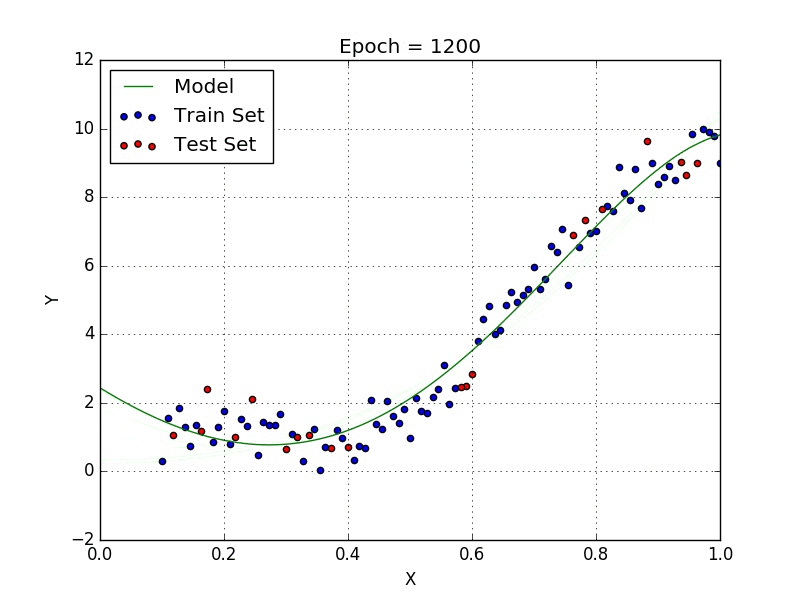

In [ ]:
import torch.nn as nn
import torch

loss = nn.MSELoss()
input = torch.randn(3, 2, requires_grad=True)
target = torch.randn(3, 2)

output = loss.forward(input, target)
output

tensor(1.4817, grad_fn=<MseLossBackward0>)


### Делаем классификацию:

**Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html))


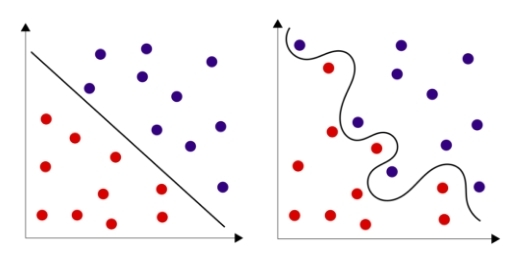

In [ ]:
# Example of target with class indices

import torch.nn as nn

loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True) # [ batch_size, class_probability ]

# [ batch_size ] -- метки каждого класса, каждая метка -- это число от [0 до 5)
target = torch.empty(3, dtype=torch.long).random_(5)

output = loss(input, target)
output

tensor(1.7126, grad_fn=<NllLossBackward0>)

### Делаем теггирование:

**Binary Cross Entropy** ([дока PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html))


Примером может быть задача тэгорования треков: один трек может именть несколько жанров: `pop`, `rock`, `jazz`, `russian`, `1980s`...

In [ ]:
sigmoid = nn.Sigmoid()
loss = nn.BCELoss()

input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)

output = loss(sigmoid(input), target)
output

tensor(0.6386, grad_fn=<BinaryCrossEntropyBackward0>)

# Оптимизация

### Моделька

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class MLP(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()

        self.inner = nn.Sequential(nn.Linear(2, 16), # заведомо довольно большая модель, чтобы очевиднее был эффект переобучения и дропаута
                                   nn.ReLU(),
                                   nn.Linear(16, 16),
                                   nn.ReLU(),
                                   nn.Linear(16, 1))

    def forward(self, x):
        return self.inner(x)


### model.parameters()


In [11]:
model = MLP()
params = model.parameters()
params_list = list(params)

In [12]:
params_list

[Parameter containing:
 tensor([[-0.0347, -0.1208],
         [-0.6353, -0.0386],
         [ 0.6646, -0.0187],
         [ 0.2019,  0.2866],
         [ 0.4751, -0.5956],
         [-0.2351,  0.2373],
         [-0.5850,  0.0589],
         [-0.6493,  0.3310],
         [ 0.3708, -0.4770],
         [-0.7047,  0.5621],
         [-0.3283,  0.1485],
         [-0.1042, -0.6949],
         [ 0.2033,  0.2610],
         [ 0.6544,  0.3812],
         [-0.5500, -0.3813],
         [ 0.5252, -0.2950]], requires_grad=True),
 Parameter containing:
 tensor([-0.4195, -0.1141,  0.6532,  0.1620, -0.0156,  0.1886, -0.4875, -0.5346,
          0.5814,  0.0093, -0.4886, -0.6859,  0.1261, -0.4279,  0.1221,  0.4609],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1818, -0.1496,  0.0246, -0.0727,  0.0311, -0.0237, -0.2092, -0.0876,
           0.0849,  0.0536, -0.1114, -0.1509,  0.0895,  0.0418, -0.0035,  0.1286],
         [ 0.1433,  0.1277, -0.0027,  0.2443,  0.0485, -0.1897,  0.1322, -0.0870,
      

In [13]:
# В этом методе градиенты всегда будут рандомными!
# В реальности данные и метки должны браться из датасета, а не из рандома
def example_compute_random_gradients(model):
    batch_size = 3
    model_input = torch.rand([batch_size, 2])
    target_batch_values = torch.randint(0, 1, [batch_size]) * 2 - 1 # -1/1 target values

    model_prediction = model.forward(model_input)

    loss = F.relu(1 - target_batch_values * model_prediction).mean()

    model.zero_grad()
    loss.backward()  # compute loss

### Hands optimizer


In [14]:
model = MLP()
example_compute_random_gradients(model)

learning_rate = 0.01

# optimization step
for p in model.parameters():
    p.data = p.data - learning_rate * p.grad

### Pytorch Optimizer

In [15]:
from torch.optim import SGD

In [16]:
model = MLP()
sgd_optimizer = SGD(model.parameters(), lr=learning_rate)

example_compute_random_gradients(model)

sgd_optimizer.step() # итериуется по сохраненным на этапе инициализации параметрам и обновляет параметры

In [17]:
## Другие оптимизаторы
from torch.optim import Adam

adam_optimizer = Adam(model.parameters(), lr=learning_rate)

example_compute_random_gradients(model)

adam_optimizer.step()

Можем вспомнить, что оптимизатор хранит статиситики по градиентам параметров!

Для хранения этих статистик тоже используется память на видео-карте.

In [19]:
adam_optimizer.state_dict()

{'state': {0: {'step': tensor(1.),
   'exp_avg': tensor([[-6.8935e-05, -8.8085e-04],
           [ 0.0000e+00,  0.0000e+00],
           [ 0.0000e+00,  0.0000e+00],
           [-4.1167e-03, -5.4188e-03],
           [ 0.0000e+00,  0.0000e+00],
           [ 2.7858e-04,  2.1449e-04],
           [-1.6628e-03, -1.4260e-03],
           [ 1.1526e-05,  1.4727e-04],
           [-1.7643e-04, -7.1596e-04],
           [ 3.6023e-03,  4.8387e-03],
           [ 0.0000e+00,  0.0000e+00],
           [ 2.2148e-03,  2.2949e-03],
           [ 2.2643e-04,  1.9419e-04],
           [ 0.0000e+00,  0.0000e+00],
           [ 1.0083e-03,  1.3525e-03],
           [-2.3277e-03, -2.2266e-03]]),
   'exp_avg_sq': tensor([[4.7520e-10, 7.7590e-08],
           [0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00],
           [1.6948e-06, 2.9363e-06],
           [0.0000e+00, 0.0000e+00],
           [7.7608e-09, 4.6005e-09],
           [2.7648e-07, 2.0334e-07],
           [1.3284e-11, 2.1690e-09],
           [3.1128

Кстати! А как работает скользящее среднее?

Text(0.5, 1.0, 'Mooving average demo')

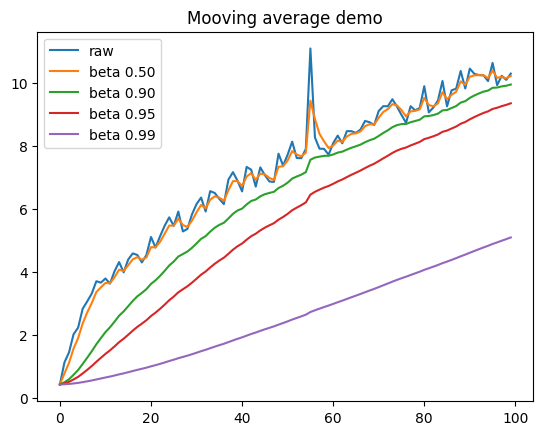

In [35]:
import matplotlib.pyplot as plt

timeseries_len = 100

outlier = torch.zeros(timeseries_len)
outlier[55] = 3

           # рандомный шум                   + квадратный корень                       + выброс
raw_data = torch.rand([timeseries_len]) + torch.sqrt(torch.arange(timeseries_len)) + outlier

beta_values = torch.tensor([ 0.5, 0.9, 0.99 ])

mooving_avarages = torch.zeros([beta_values.shape[0], timeseries_len])
mooving_avarages[:, 0] = raw_data[0]

for i in range(1, timeseries_len):
    mooving_avarages[:, i] = mooving_avarages[:, i-1] * beta_values + (1-beta_values) * raw_data[i]

plt.plot(raw_data, label='raw')
for beta_i, beta in enumerate(beta_values.numpy().tolist()):
    plt.plot(mooving_avarages[beta_i, :], label=f"beta {beta:.2f}")

plt.legend()
plt.title("Mooving average demo")

# Регуляризация

In [ ]:
import torch
import torch.nn as nn

## Dropout

[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [ ]:
dropout = nn.Dropout(p=0.5)
dropout.eval()
print(dropout.training) # важный флажок для дропаута - тк дропаут имеет разное поведение в процессе обучения и в процессе вычисления сети

dropout

False


Dropout(p=0.5, inplace=False)

In [ ]:
list(dropout.parameters())

[]

In [ ]:
t = torch.rand([3, 5], dtype=torch.float32)

print("t.mean()", t.mean().item())

t

t.mean() 0.4265078008174896


tensor([[0.2502, 0.4522, 0.7943, 0.9318, 0.1082],
        [0.7405, 0.4417, 0.2077, 0.4756, 0.1264],
        [0.6561, 0.2195, 0.0856, 0.5912, 0.3166]])

In [ ]:
# Sequential( Linear(2, 16), Dropout(0.3) ) #  пример использования

In [ ]:
# 1 / (1-p)

In [ ]:
dropout.eval()
t_dropouted = dropout(t)

print("t_dropouted.mean()", t_dropouted.mean().item())

assert torch.allclose(t_dropouted, t), "eval dropout doesn't change input tensor"

t_dropouted

t_dropouted.mean() 0.4265078008174896


tensor([[0.2502, 0.4522, 0.7943, 0.9318, 0.1082],
        [0.7405, 0.4417, 0.2077, 0.4756, 0.1264],
        [0.6561, 0.2195, 0.0856, 0.5912, 0.3166]])

In [ ]:
dropout.train()
t_dropouted = dropout(t)

print("t_dropouted.mean()", t_dropouted.mean().item())

print("zeros count", (t_dropouted == 0.0).sum().item(), "of", t_dropouted.numel())

t_dropouted

t_dropouted.mean() 0.4760642647743225
zeros count 7 of 15


tensor([[0.0000, 0.9044, 0.0000, 1.8637, 0.0000],
        [1.4810, 0.8835, 0.0000, 0.9512, 0.2528],
        [0.0000, 0.0000, 0.1712, 0.0000, 0.6332]])

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout()

m = Model()
m.training

True

In [ ]:
m = m.eval()
m.dropout.training

False

## LabelSmoothing

In [ ]:
nn.CrossEntropyLoss(label_smoothing=0.1)

CrossEntropyLoss()

**Несглаженные метки:**

| Метка мема | Label Proba |
| --- | --- |
| feel it (какой пацан) | 1.0 |
| Hide The Pain Harold | 0.0 |
| That is fine  | 0.0 |
| Roll Safe Think About It | 0.0 |


**Сглаженные метки:**

| Метка мема | Label Proba |
| --- | --- |
| feel it (какой пацан) | 0.9 |
| Hide The Pain Harold | 0.03 |
| That is fine  | 0.03 |
| Roll Safe Think About It | 0.03 |



## WeightDecay

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (..., weight_decay=0.1)

* [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

Stack Overflow: [AdamW and Adam with weight decay](https://stackoverflow.com/questions/64621585/adamw-and-adam-with-weight-decay)

В чем разница:

* Adam + weight_decay --- регуляризация идет через градиенты
```
final_loss = loss + wd * all_weights.pow(2).sum() / 2
```

* AdamW --- регуляризация не идет через лосс
```
w = w - lr * w.grad - lr * wd * w
```


In [ ]:
import torch.optim as optim

dummy_module_params = nn.Linear(1, 1).parameters()
adam = optim.Adam(dummy_module_params, weight_decay=0.01)

dummy_module_params = nn.Linear(1, 1).parameters()
adamw = optim.AdamW(dummy_module_params, weight_decay=0.1)

# Обновим Trainer и нашу модель


* Добавим поддержку lr_sheduler
* В модельку добавим дропаут

In [ ]:
from copy import deepcopy

from tqdm.auto import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

from torchvision.transforms import ToTensor

from torch.optim import Adam

# ничего нового, копипаста с предыдущего сема
class FMNISTImageSet:
    def __init__(self, train=True, transform=None):
        self.data = FashionMNIST("./tmp", train=train, download=True)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        # сделайте одноканальную картинку [1, 28, 28] с float32
        sample, label = self.data[item]

        if self.transform is not None:
            sample = self.transform(sample)
        else:
            sample = np.array(sample, dtype=np.float32)[None:, ...] / 255


        return dict(
            sample=sample,
            label=label,
        )

fmnist_train = FMNISTImageSet(train=True, transform=ToTensor())
fmnist_val = FMNISTImageSet(train=False, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 14649696.87it/s]


Extracting ./tmp/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 264109.27it/s]


Extracting ./tmp/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4850023.71it/s]


Extracting ./tmp/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./tmp/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5721324.06it/s]

Extracting ./tmp/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./tmp/FashionMNIST/raw



In [ ]:
# добавили dropout_p
class MLPModel(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()

        self.inner = nn.Sequential(nn.Flatten(),
                                   nn.Linear(784, 10000), # заведомо довольно большая модель, чтобы очевиднее был эффект переобучения и дропаута
                                   nn.Dropout(p=dropout_p),
                                   nn.ReLU(),
                                   nn.Linear(10000, 10))

    def forward(self, x):
        return self.inner(x)

    def compute_all(self, batch):  # удобно сделать функцию, в которой вычисляется лосс по пришедшему батчу
        x = batch['sample']
        y = batch['label']
        logits = self.inner(x)

        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)

        return loss, metrics


# добавили lr_scheduler lr_scheduler_type
# добавили post_train_batch post_val_batch post_train_stage post_val_stage
class Trainer:
    def __init__(self, model: nn.Module, optimizer,
                 train_dataset: Dataset, val_dataset: Dataset,
                 tboard_log_dir: str = './tboard_logs/', batch_size: int = 128,
                 lr_scheduler=None, lr_scheduler_type=None,
                 ):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size


        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_type = lr_scheduler_type
        if lr_scheduler_type not in [None, 'per_batch', 'per_epoch']:
            raise ValueError("lr_scheduler_type must be one of: None, 'per_batch', 'per_epoch'. "
                             f"Not: {lr_scheduler_type}")

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)

        self.global_step = 0
        self.log_writer = SummaryWriter(log_dir=tboard_log_dir)


    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def post_train_batch(self):
        # called after every train batch
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_batch':
            self.lr_scheduler.step()

    def post_val_batch(self):
        pass

    def post_train_stage(self):
        pass

    def post_val_stage(self, val_loss):
        # called after every end of val stage (equals to epoch end)
        if self.lr_scheduler is not None and self.lr_scheduler_type == 'per_epoch':
            self.lr_scheduler.step(val_loss)

        return

    def train(self, num_epochs: int):
        model = self.model
        optimizer = self.optimizer

        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')

        for epoch in tqdm(range(num_epochs)):
            model.train()
            for batch in train_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                self.post_train_batch()
                for k, v in details.items():
                    self.log_writer.add_scalar(k + "/train", v, global_step=self.global_step)
                self.global_step += 1

            self.post_train_stage()

            with torch.no_grad():
                model.eval()
                val_losses = []
                for batch in val_loader:
                    batch = {k: v.to(self.device) for k, v in batch.items()}
                    loss, details = model.compute_all(batch)
                    for k, v in details.items():
                        self.log_writer.add_scalar(k + '/validation', v, global_step=self.global_step)
                    val_losses.append(loss.item())
                    self.post_val_batch()

                val_loss = np.mean(val_losses)
                self.post_val_stage(val_loss)

                if val_loss < best_loss:
                    self.save_checkpoint("./best_checkpoint.pth")
                    best_loss = val_loss


### Не забудь поменять Runtime Type в колабе на GPU!

In [ ]:
import torch.utils.data

# берем часть исходной обучающей выборки для большей наглядности эффекта применения дропаута
# на большом датасете сложнее переобучиться, поэтому мы искусственно уменьшаем его для наглядности на занятии
# на практике не надо так делать!
fmnist_train_subset = torch.utils.data.Subset(fmnist_train, range(0, len(fmnist_train), 400))

### `dropout=0`

In [ ]:
model = MLPModel(dropout_p=0.)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(model, optimizer, fmnist_train_subset, fmnist_val, tboard_log_dir="./tboard_logs_no_dropout")

trainer.train(30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./tboard_logs_no_dropout

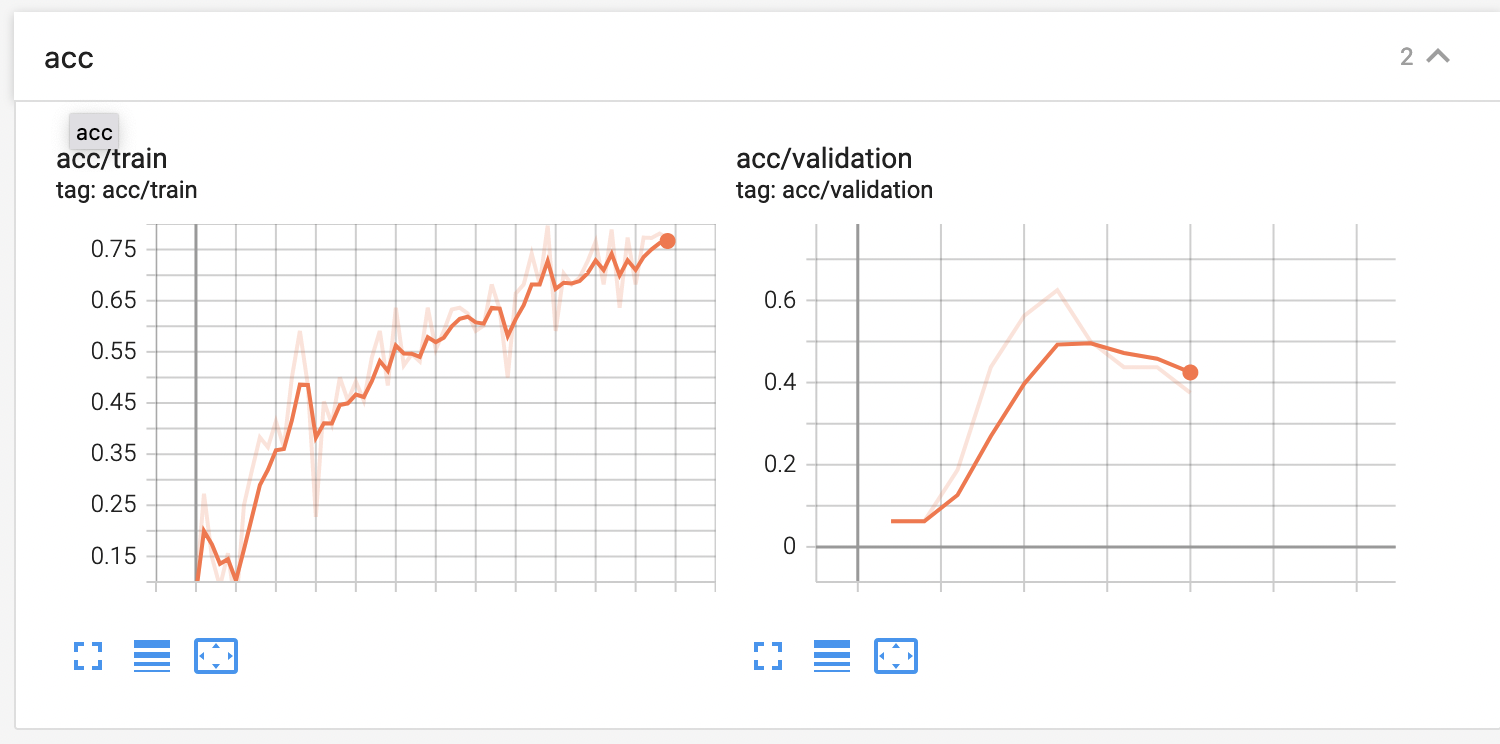

### `dropout=0.3`

In [ ]:
model = MLPModel(dropout_p=0.3)
optimizer = Adam(model.parameters(), lr=3e-3)

trainer = Trainer(model, optimizer, fmnist_train_subset, fmnist_val, tboard_log_dir="./tboard_logs_with_dropout")

trainer.train(30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
%tensorboard --logdir ./tboard_logs_with_dropout

Класс! С дропаутом получилось добиться `accuracy~=0.7`. Модель без dropout переобучилась на обучеющей выборке и на вализации для нее получилось, что `accuracy<0.5`


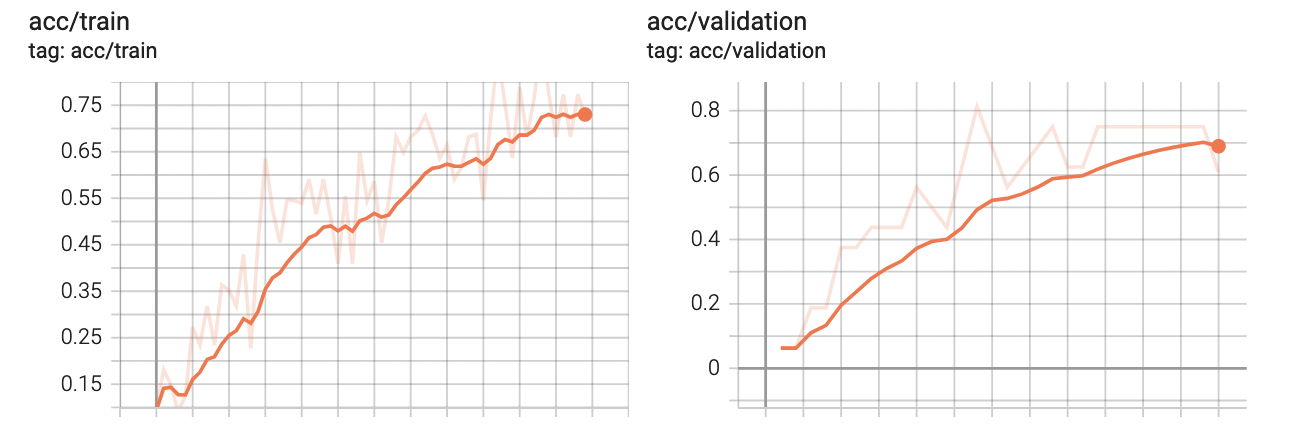

# LR Scheduler

Два типа расписаний:

- по эпохам ([StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html), [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), ...)
    ```
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    for epoch in range(epochs):
        train(...)
        validate(...)
        scheduler.step()
    ```


- по батчам ([Cyclic](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CyclicLR.html), [1cycle](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR), ...)
    ```
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
    for epoch in range(epochs):
        # train(...)
        for batch in data_loader:
            train_batch(...)
            scheduler.step()
        # validate(...)
    ```

In [ ]:
def show_scheduler(scheduler, label=None):
    lr_history = []

    if label is None:
        label = str(scheduler)

    for i in range(100):
        lr_history.append(scheduler.get_last_lr()[0])
        scheduler.step()

    plt.plot(lr_history, label=label)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Text(0.5, 1.0, 'StepLR')

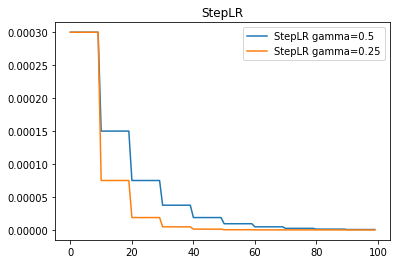

In [ ]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5), label="StepLR gamma=0.5" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.25), label="StepLR gamma=0.25" )

plt.legend()

plt.title("StepLR")

#### Пример обучения с использованием step lr
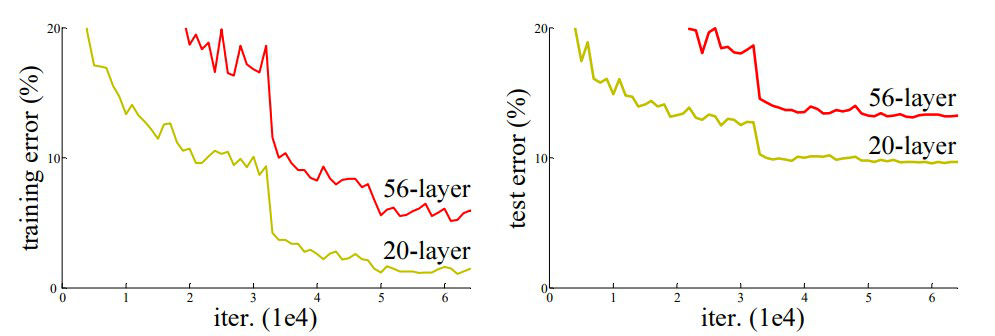

Text(0.5, 1.0, 'CyclicLR')

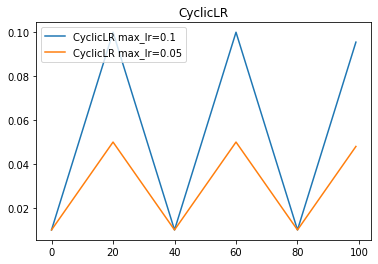

In [ ]:
optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.1" )

optimizer = Adam(model.parameters(), lr=3e-4)
show_scheduler( torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.05, step_size_up=20, cycle_momentum=False), label="CyclicLR max_lr=0.05" )

plt.legend()

plt.title("CyclicLR")

**Вопрос:** в каких случаях может быть полезен `CyclicLR`? Зачем повышать `lr`?

<!-- если во время оптимизации попали в локальный минимум, с увеличением lr можем выскочить из этого локального минимума и попасть в более глубокую 'лунку' -->

#### Обучим модельку с шедулером

**Hint** Хорошей идеей было бы добавить график изменения lr в тензорборд


In [ ]:
model = MLPModel(lr_scheduler_type='per_batch')
optimizer = Adam(model.parameters(), lr=3e-4)
very_model_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.005, step_size_up=300, cycle_momentum=False)
model.lr_scheduler = very_model_scheduler

trainer = Trainer(model, optimizer, fmnist_train, fmnist_val)
trainer.train(3)


100%|██████████| 79/79 [00:01<00:00, 69.16it/s]


# WarmUp

**Проблема:** очень большие сетки может сильно разнести, если сразу начать их оптимизировать на больших батчах


Чтобы сеть не расходилась сразу, можно постепенно увеличивать lr --- тогда оптимизаторы постепенно накопят статистики по разным группам параметров

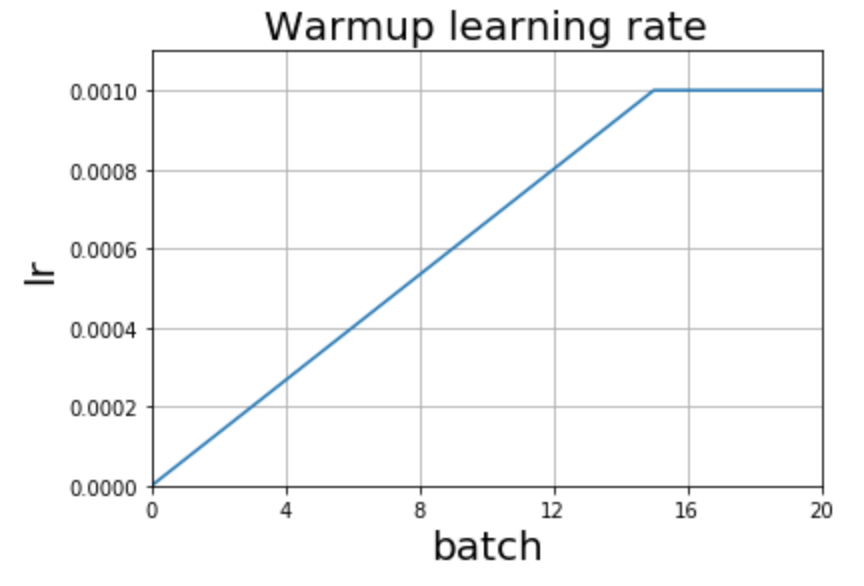


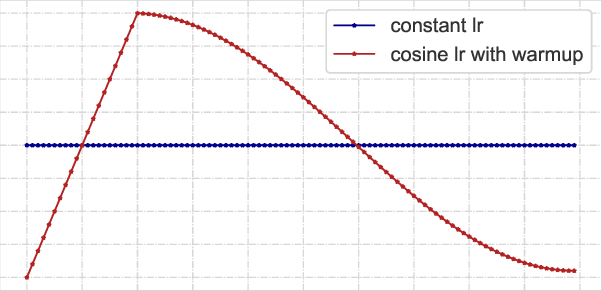

# Блиц по практике обучения нейросетей


### Может ли быть лосс отрицательным?

### Зачем нужен lr warmup?

<!---

Используется для обучения больших сетей для того, чтобы

-->

### Зачем нужен lr scheduling?

<!---

Чтобы получить лучшее качество модели или увеличить скорость обучения. Например, в начале обучения мы хотим побыстрее прийти к области с точкой оптимума. Но после того как мы к ней приблизились мы можем захотеть уменьшить lr для того, чтобы более точно подобрать значения параметров

--->



### Почему мы рассмотрели задачу об особенностях хранения чисел с плавующей точкой?

<!---

При маленьких значениях lr веса сети не будут обновляться из-за того, что операции с числаим с плавующей точкой имеют ограниченную точность

-->

### Как нужно изменить lr, если мы увеличили batch_size в 3 раза?

<!---

Для того, чтобы сохранить такую же скорость оптимизации LR нужно тоже увеличить в 3 раза.*

* Для определенной задачи, батч сайза


PS Хотя вообще говоря, это очень спорно. Можно придумать много граничных кейсов. Например, для простых задач может быть даже более эффективно обучаться на маленьком батчсайзе. Потому что чем меньше батч, тем быстрее вычисления и тем больше шагов оптимизации мы сможем сделать за единицу времени.

-->


### Как выбрать хорошие начальные значения для lr?

<!---

С помощью LR Finder'а

Строим зависимость Loss(learning_rate) и ищем точку перегиба. Диапозон неплохих lr будет начинаться в точке перегиба (возможно чуть левее), когда сеть начинает учиться, а заканчиваться до момента, когда лосс начинает шуметь, флуктуировать, колбасить

--->


### Как будет обучаться модель, если в нее добавить слой `nn.Dropout(p=1.0)`

<!-- Никак, потому что такой слой просто занулит тензор полностью -->

### Зачем внутри `Dropout` делается умножение на `1/(1-p)`? Что будет, если этого не сделать?

### Как изменяется поведение модуля `nn.Dropout` после того, как мы переключили модель в режим вычисления (`model.eval()`)?

<!-- Из доки торча: "During evaluation the module simply computes an identity function." -- лучше и не скажешь) https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html -->

### Для чего вообще нужен `nn.Dropout`?

<!-- Способ регуляризации, с дропаутом модели сложнее переобучиться на тренировочный датасет, улучшается обобщающая способность сети -->


### Мы хотим обучить модель на `1M` параметров с помощью `SGD` и с помощью `Adam`. Как изменится необходимый объем видеопамяти для обучения модели в зависимости от оптимизатора?

### Зачем `Adam` использует скользящее среднее для вычисления моментов? Можно ведь использовать значение момента с предыдущего шага.

### Зачем мы используем GPU для обучения/вычисления нейросетей?

# Домашки:

* dropout
* optimization